In [3]:
import pandas as pd

In [4]:
import pandas as pd
import warnings

# Optional: suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Load the stock price CSV
price_df = pd.read_csv('/kaggle/input/msft-prices/msft_price-history-04-08-2025.csv')

# Clean column names (make all lowercase and strip extra spaces)
price_df.columns = [col.lower().strip() for col in price_df.columns]

# Rename 'time' to 'date' and 'last' to 'close'
price_df = price_df.rename(columns={'time': 'date', 'last': 'close'})

# Filter rows that have proper date strings - assuming the format is YYYY-MM-DD
# (This filters out any footer or extraneous lines)
price_df = price_df[price_df['date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

# Convert the 'date' column to datetime
price_df['date'] = pd.to_datetime(price_df['date'])

# Keep only the columns we need
price_df = price_df[['date', 'close']].sort_values('date')
print("Price Data:")
print(price_df.head())


Price Data:
         date   close
63 2025-01-03  423.35
62 2025-01-06  427.85
61 2025-01-07  422.37
60 2025-01-08  424.56
59 2025-01-10  418.95


In [5]:
# Load the sentiment CSV file
df = pd.read_csv('/kaggle/input/hehehee/sentiment_analyzed_news.csv')

# Clean column names (if needed)
df.columns = [col.lower().strip() for col in df.columns]

# Convert the 'date' column to datetime. 
# (Your data shows both date and time; we will later aggregate by date.)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['date'])

# Print a preview to verify
print("Sentiment Data:")
print(df.head())


Sentiment Data:
                 date                                            content  \
0 2024-07-30 07:00:00  Microsoft Cloud strength drives fourth quarter...   
1 2024-08-20 07:00:00  Microsoft's dominant 21st century offers a key...   
2 2024-08-21 07:00:00  Microsoft again ranked number one in modern en...   
3 2024-08-22 07:00:00  Microsoft at IBC2024: Reimagining media with A...   
4 2024-09-16 07:00:00  Finastra’s Copilot revolution: How AI is resha...   

        source  source_weight sentiment sentiment_strength  \
0  Google News            1.0  positive             strong   
1  Google News            1.0  positive             strong   
2  Google News            1.0  positive             strong   
3  Google News            1.0   neutral                NaN   
4  Google News            1.0  positive             strong   

   raw_sentiment_score  weighted_sentiment  
0             1.000000            1.000000  
1             0.999210            0.999210  
2             0.999

In [6]:
# Remove the time component and keep only the date (set time to midnight)
df['date'] = df['date'].dt.floor('d')

sentiment_map = {
    'positive': 1,
    'neutral': -0.5,
    'negative': -1
}
df['sentiment'] = df['sentiment'].map(sentiment_map)

# Aggregate by date:
# For raw sentiment, we'll assume your column is named 'raw_sentiment_score'
# and for weighted sentiment, your column is 'weighted_sentiment'
sentiment_agg = df.groupby('date').agg({
    'sentiment': 'mean',
    'weighted_sentiment': 'mean'
}).reset_index()

print("Aggregated Sentiment Data:")
print(sentiment_agg.head())


Aggregated Sentiment Data:
        date  sentiment  weighted_sentiment
0 2024-07-30        1.0            1.000000
1 2024-08-20        1.0            0.999210
2 2024-08-21        1.0            0.999730
3 2024-08-22       -0.5            0.000000
4 2024-09-16        1.0            0.901537


In [7]:
# Merge on the 'date' column using an inner join to keep only dates in common
merged_df = pd.merge(price_df, sentiment_agg, on='date', how='inner')
merged_df = merged_df.sort_values('date').reset_index(drop=True)
print("Merged Data:")
print(merged_df.head())


Merged Data:
        date   close  sentiment  weighted_sentiment
0 2025-01-06  427.85        1.0            0.532901
1 2025-01-07  422.37        1.0            0.999181
2 2025-01-10  418.95        1.0            1.000000
3 2025-01-13  417.19        0.0            0.333292
4 2025-01-16  424.58       -0.5            0.000000


In [8]:
from sklearn.model_selection import train_test_split

# Create two copies of the dataset for the two experiments:
data_raw = merged_df[['date', 'close', 'sentiment']].dropna()
data_weighted = merged_df[['date', 'close', 'weighted_sentiment']].dropna()

# For our experiment, we'll simply use the sentiment score to predict the close price.
# We drop the date column for modeling.
X_raw = data_raw[['sentiment']]
y_raw = data_raw['close']

X_weighted = data_weighted[['weighted_sentiment']]
y_weighted = data_weighted['close']

# Split into train and test sets (80/20 split)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
X_weighted_train, X_weighted_test, y_weighted_train, y_weighted_test = train_test_split(X_weighted, y_weighted, test_size=0.2, random_state=42)


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Model using raw sentiment
model_raw = GradientBoostingRegressor(random_state=42)
model_raw.fit(X_raw_train, y_raw_train)
pred_raw = model_raw.predict(X_raw_test)
rmse_raw = mean_squared_error(y_raw_test, pred_raw, squared=False)

# Model using weighted sentiment
model_weighted = GradientBoostingRegressor(random_state=42)
model_weighted.fit(X_weighted_train, y_weighted_train)
pred_weighted = model_weighted.predict(X_weighted_test)
rmse_weighted = mean_squared_error(y_weighted_test, pred_weighted, squared=False)

print("RMSE using Weighted sentiment: {:.2f}".format(rmse_raw))
print("RMSE using Raw sentiment: {:.2f}".format(rmse_weighted))


RMSE using Weighted sentiment: 17.86
RMSE using Raw sentiment: 21.38


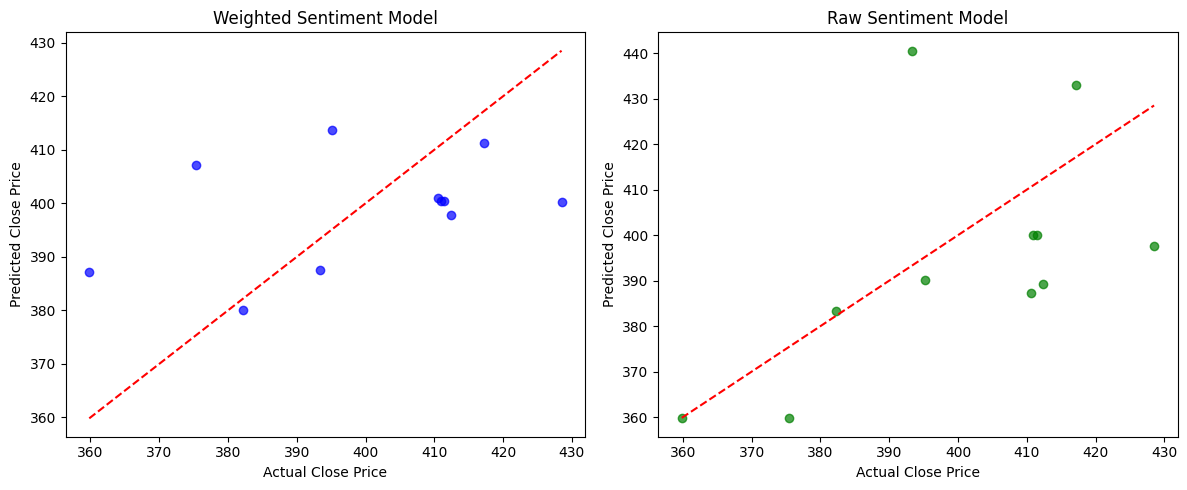

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for raw sentiment model
plt.subplot(1, 2, 1)
plt.scatter(y_raw_test, pred_raw, alpha=0.7, color='blue')
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Weighted Sentiment Model")
plt.plot([y_raw_test.min(), y_raw_test.max()], [y_raw_test.min(), y_raw_test.max()], 'r--')

# Plot for weighted sentiment model
plt.subplot(1, 2, 2)
plt.scatter(y_weighted_test, pred_weighted, alpha=0.7, color='green')
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title("Raw Sentiment Model")
plt.plot([y_weighted_test.min(), y_weighted_test.max()], [y_weighted_test.min(), y_weighted_test.max()], 'r--')

plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_percentage_error, brier_score_loss
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# ========== PREPARE TARGET ==========

merged_df['target'] = (merged_df['close'].shift(-1) > merged_df['close']).astype(int)
merged_df.dropna(inplace=True)

features_raw = merged_df[['sentiment']]
features_weighted = merged_df[['weighted_sentiment']]
target = merged_df['target']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features_raw, target, test_size=0.2, stratify=target, random_state=42)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(features_weighted, target, test_size=0.2, stratify=target, random_state=42)

# ========== MODELS ==========
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

# ========== EVALUATION ==========
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else preds

    return {
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, preds), 4),
        'Precision': round(precision_score(y_test, preds, zero_division=0), 4),
        # 'Recall': round(recall_score(y_test, preds), 4),
        # 'F1 Score': round(f1_score(y_test, preds), 4),
        # 'ROC AUC': round(roc_auc_score(y_test, probs), 4),
        'RMSE': round(np.sqrt(mean_squared_error(y_test, probs)), 4),
        # 'MAPE': round(mean_absolute_percentage_error(y_test, probs), 4),
        'Brier Score': round(brier_score_loss(y_test, probs), 4)
    }

results = []
for name, model in models.items():
    res_raw = evaluate_model(name + " (Raw)", model, X_train_r, X_test_r, y_train_r, y_test_r)
    res_weighted = evaluate_model(name + " (Weighted)", model, X_train_w, X_test_w, y_train_w, y_test_w)
    results.extend([res_raw, res_weighted])

results_df = pd.DataFrame(results)

# ========== FORMAT DECIMALS ==========
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# ========== SIDE-BY-SIDE MODEL COMPARISONS ==========
model_names = ['XGBoost', 'RandomForest', 'GradientBoosting', 'KNN']

for model in model_names:
    print(f"\n=== 📊 {model} Performance Comparison ===")
    model_df = results_df[results_df['Model'].str.contains(model)]
    display(model_df.set_index('Model').T)


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)



=== 📊 XGBoost Performance Comparison ===


Model,XGBoost (Raw),XGBoost (Weighted)
Accuracy,0.2727,0.3636
Precision,0.2857,0.3750
RMSE,0.6455,0.6126
Brier Score,0.4166,0.3753



=== 📊 RandomForest Performance Comparison ===


Model,RandomForest (Raw),RandomForest (Weighted)
Accuracy,0.5455,0.7273
Precision,0.5000,0.6667
RMSE,0.5277,0.5416
Brier Score,0.2785,0.2933



=== 📊 GradientBoosting Performance Comparison ===


Model,GradientBoosting (Raw),GradientBoosting (Weighted)
Accuracy,0.5455,0.7273
Precision,0.5000,0.6667
RMSE,0.5516,0.5271
Brier Score,0.3042,0.2778



=== 📊 KNN Performance Comparison ===


Model,KNN (Raw),KNN (Weighted)
Accuracy,0.4545,0.4545
Precision,0.3333,0.4286
RMSE,0.5427,0.5427
Brier Score,0.2945,0.2945


In [23]:
print(results_df.columns.tolist())


['Model', 'Accuracy', 'Precision', 'RMSE', 'Brier Score']


<ipython-input-26-3c6046521fd2>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


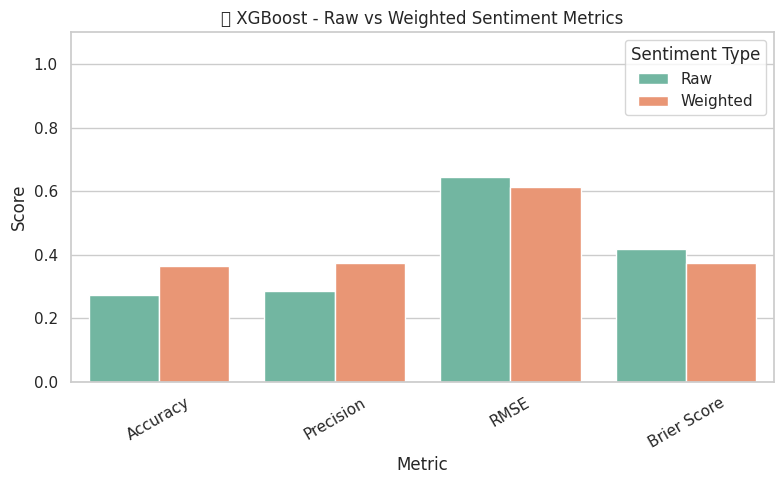

<ipython-input-26-3c6046521fd2>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


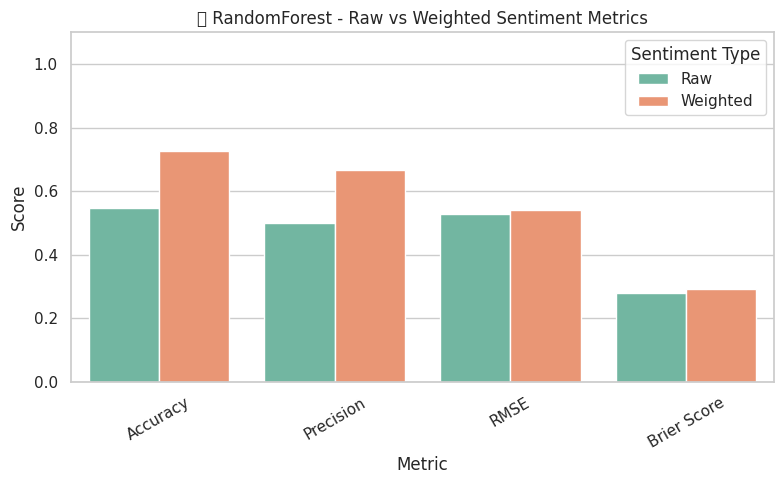

<ipython-input-26-3c6046521fd2>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


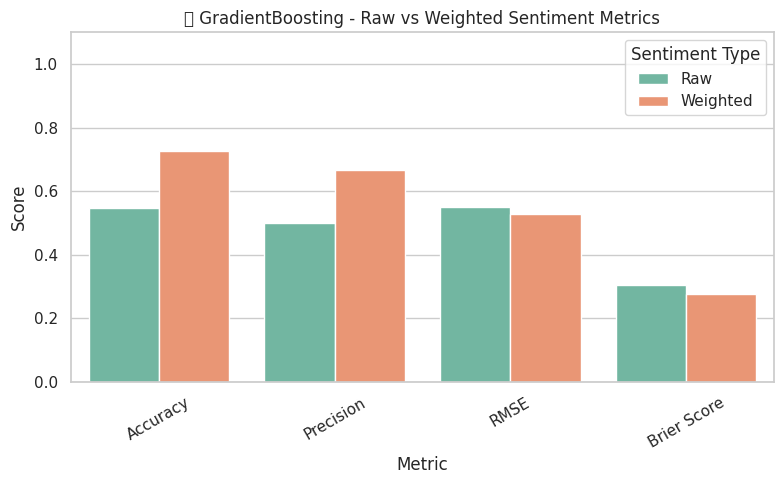

<ipython-input-26-3c6046521fd2>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


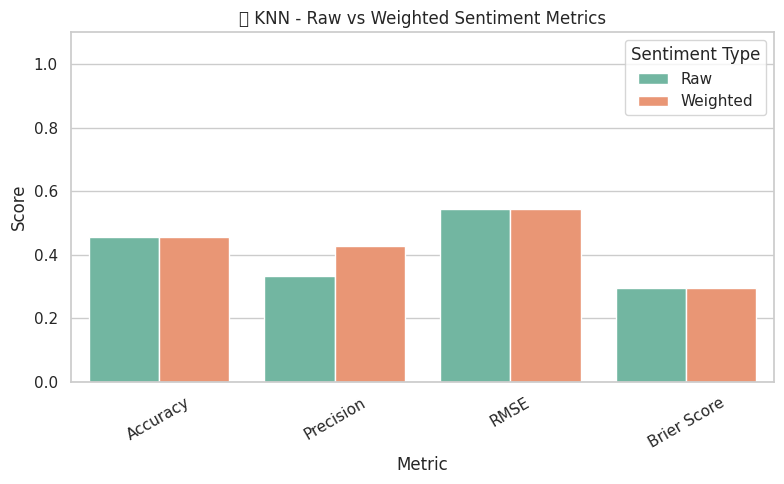

<ipython-input-26-3c6046521fd2>:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


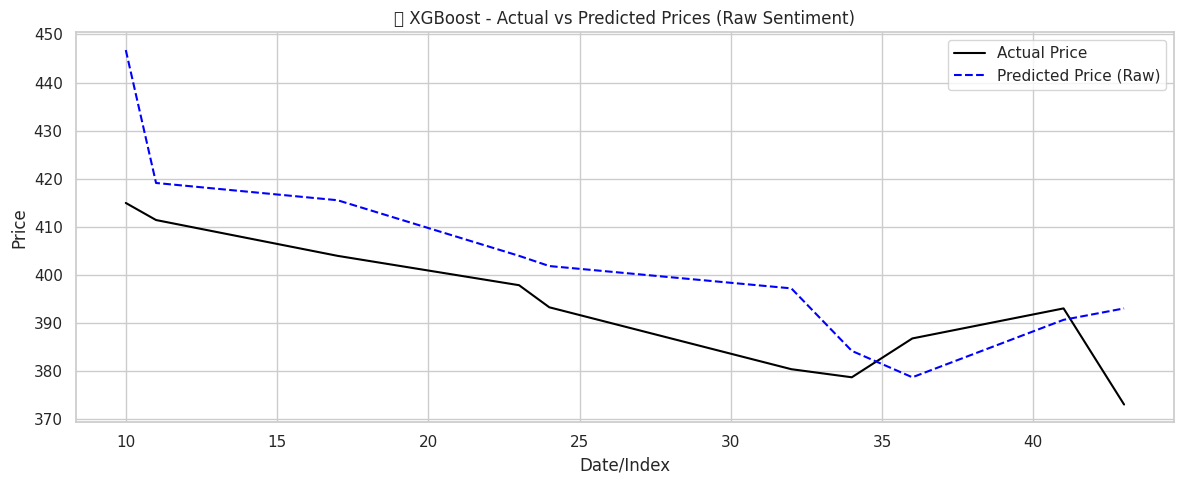

<ipython-input-26-3c6046521fd2>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


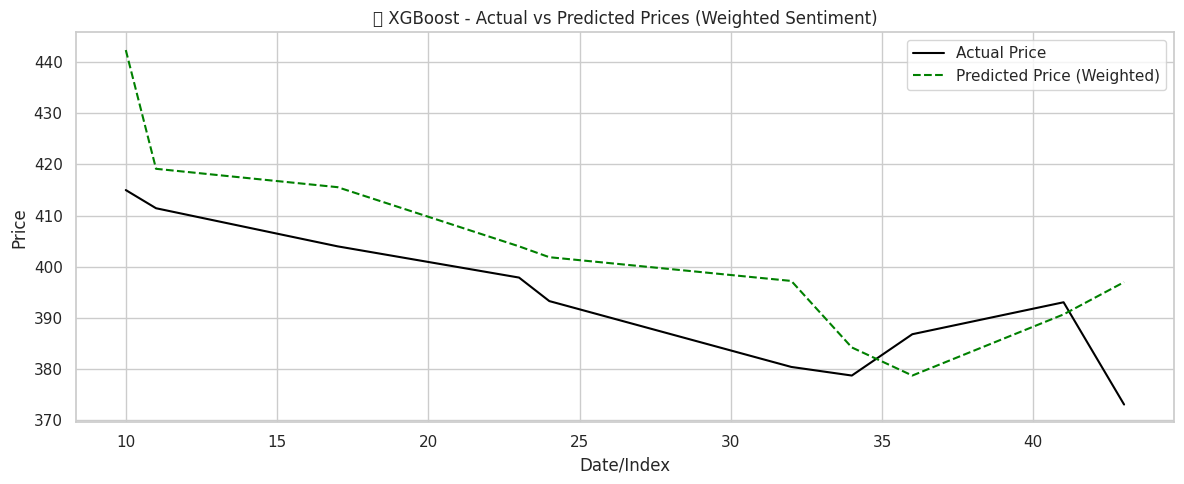

<ipython-input-26-3c6046521fd2>:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


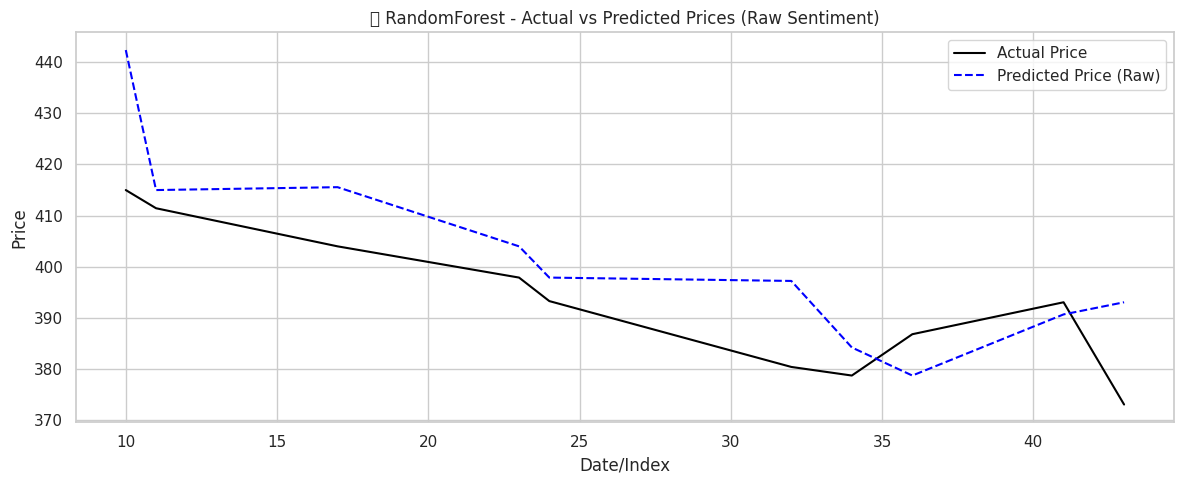

<ipython-input-26-3c6046521fd2>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


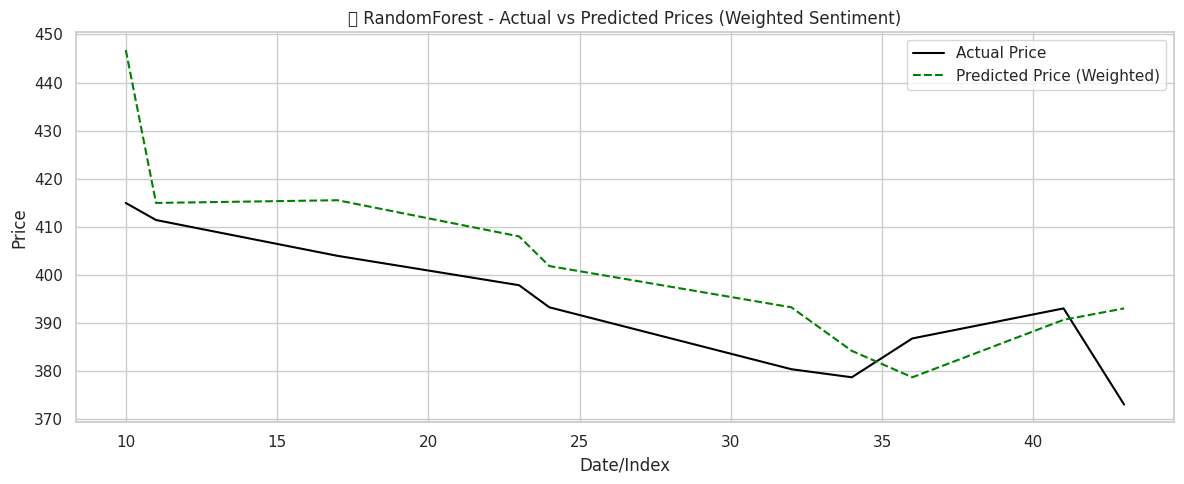

<ipython-input-26-3c6046521fd2>:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


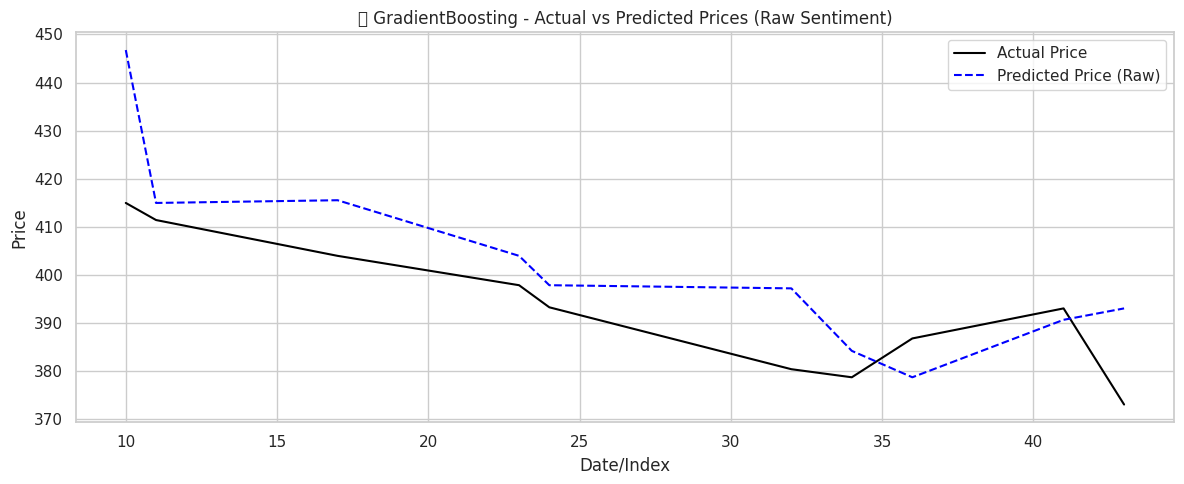

<ipython-input-26-3c6046521fd2>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


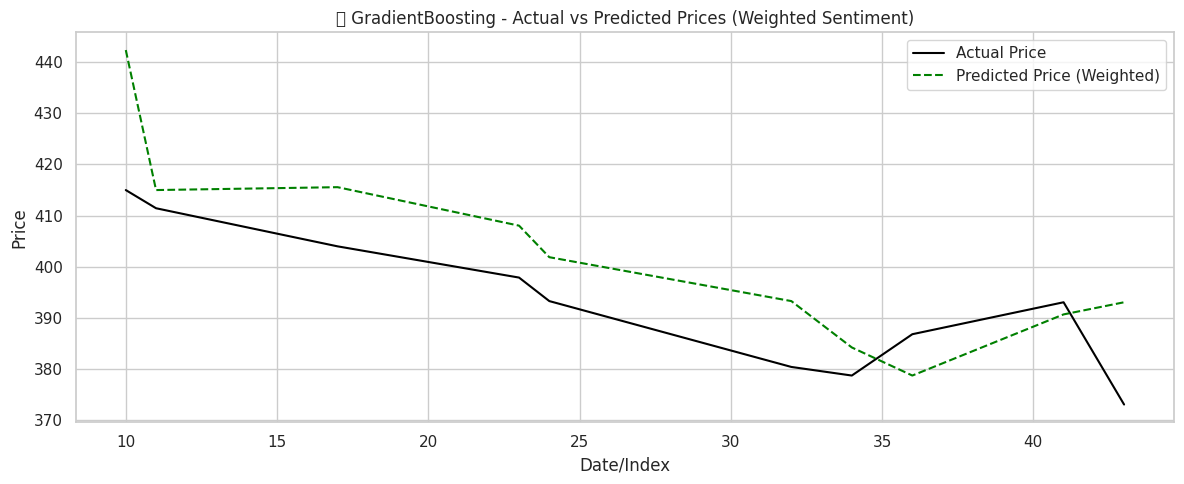

<ipython-input-26-3c6046521fd2>:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


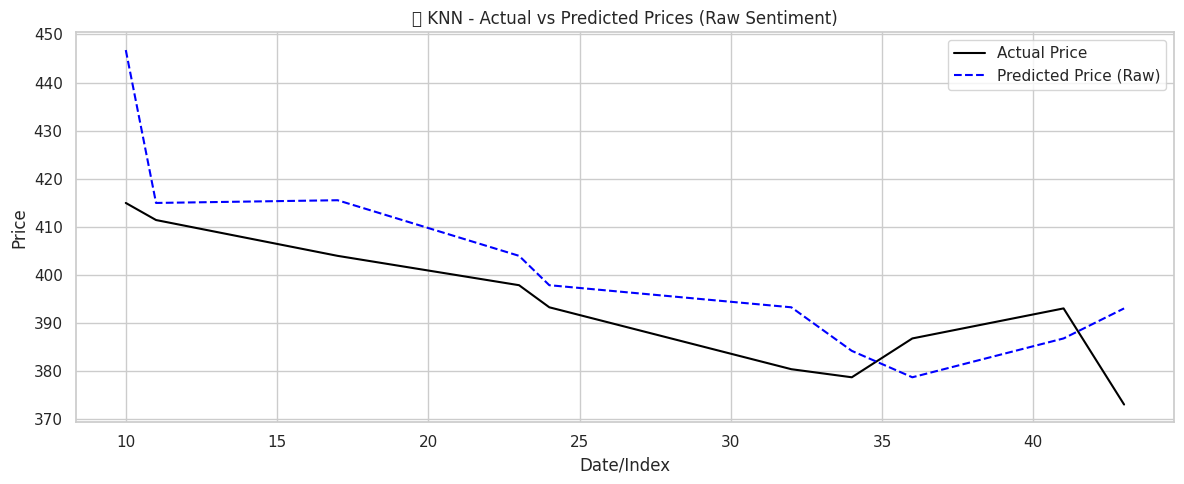

<ipython-input-26-3c6046521fd2>:74: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


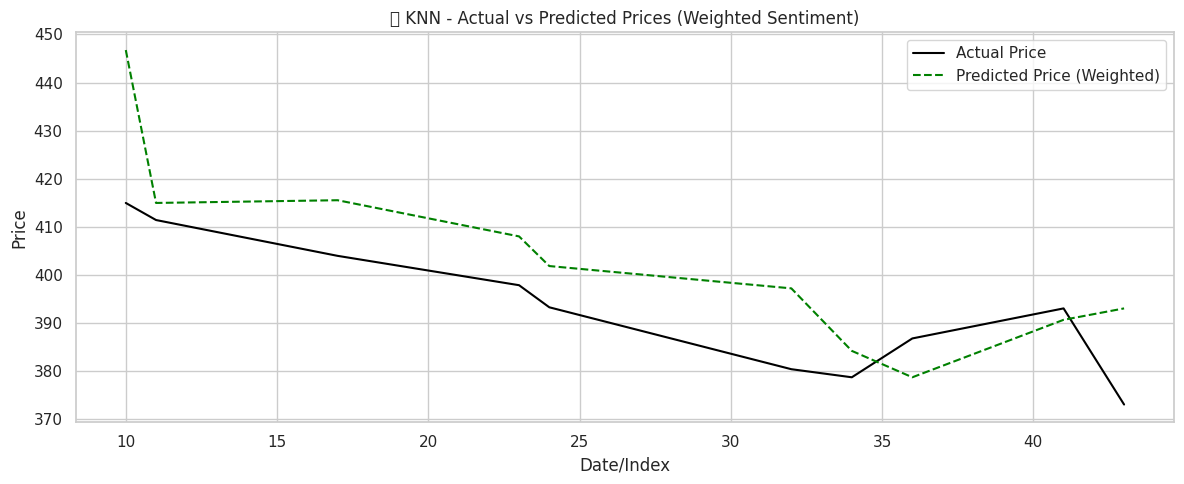

<ipython-input-26-3c6046521fd2>:90: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


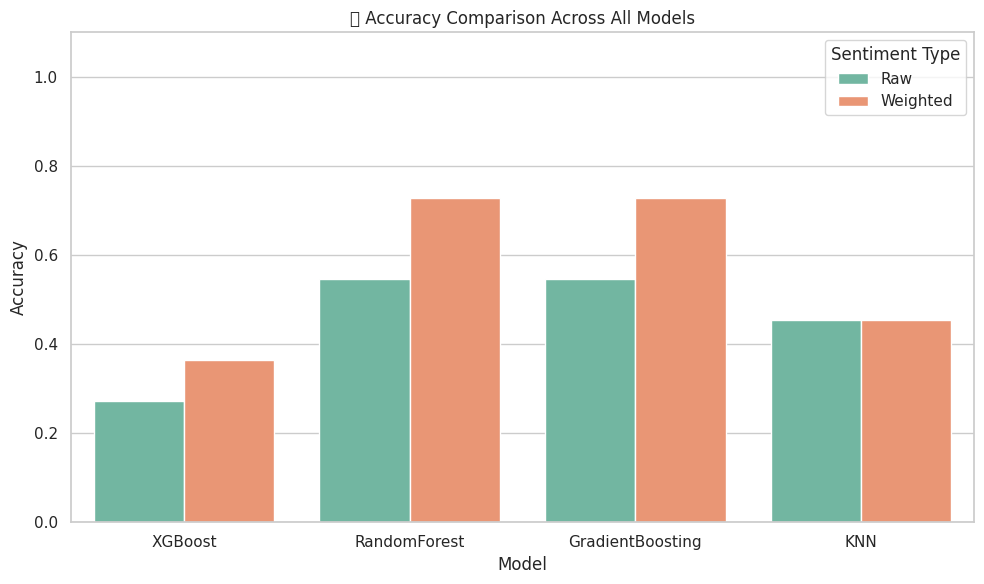

<ipython-input-26-3c6046521fd2>:90: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


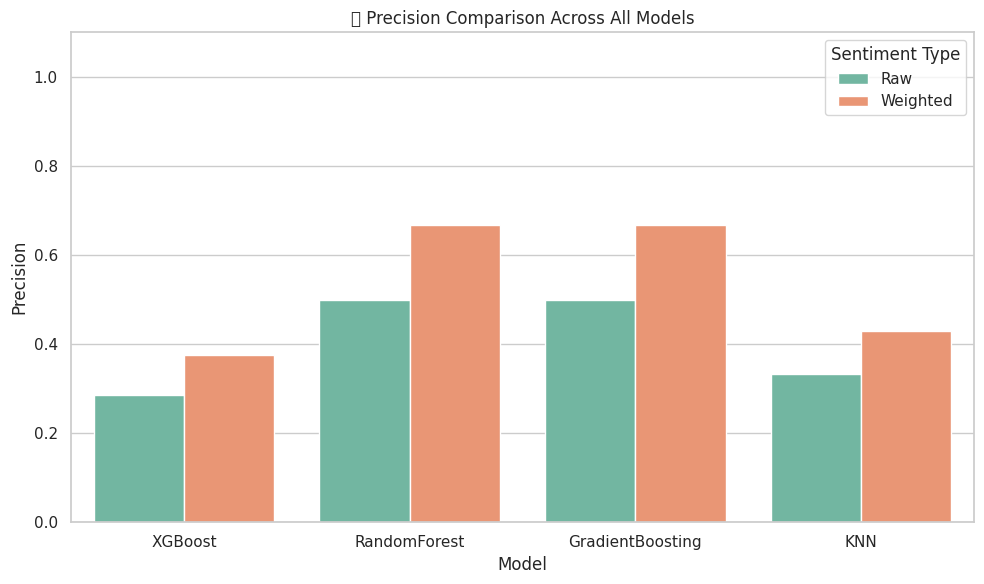

<ipython-input-26-3c6046521fd2>:90: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


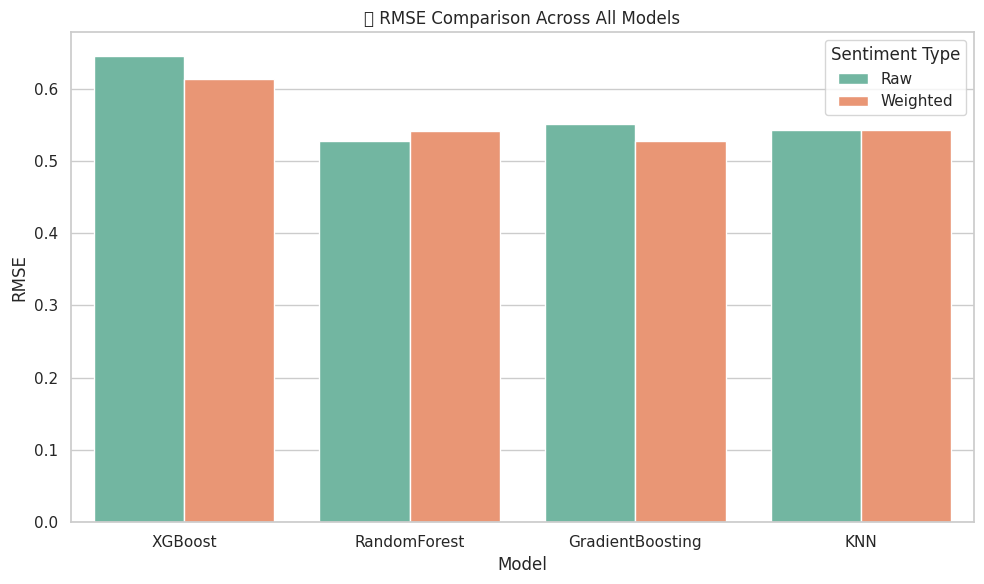

<ipython-input-26-3c6046521fd2>:90: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


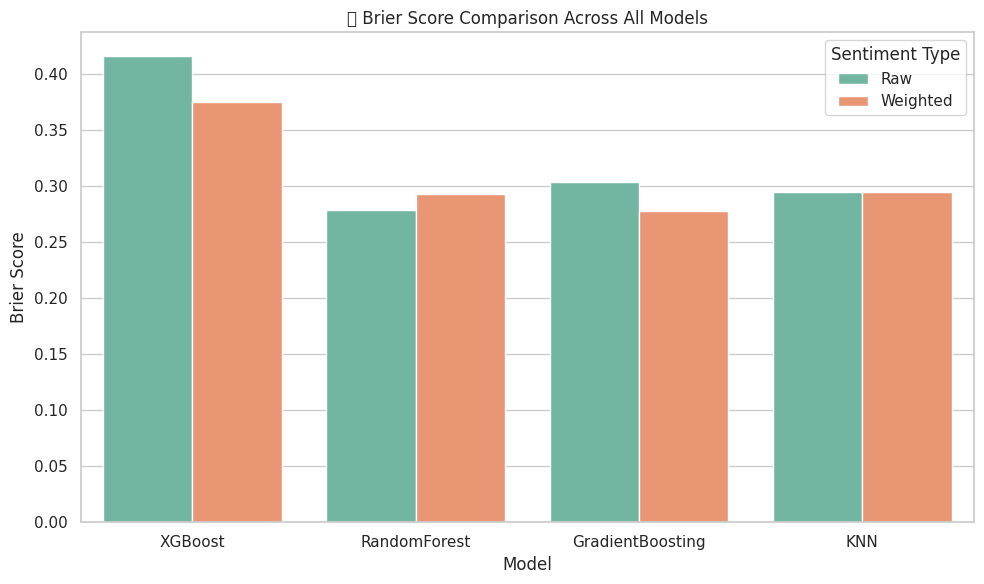

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Setup common ===
metrics_to_plot = ['Accuracy', 'Precision', 'RMSE', 'Brier Score']
model_names = ['XGBoost', 'RandomForest', 'GradientBoosting', 'KNN']

# === 1. Bar Chart for Each Model: Raw vs Weighted per Metric ===
for model in model_names:
    df_model = results_df[results_df['Model'].str.contains(model)]
    melted = df_model.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')
    melted['Type'] = melted['Model'].apply(lambda x: 'Weighted' if 'Weighted' in x else 'Raw')

    plt.figure(figsize=(8, 5))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Type', palette='Set2')
    plt.title(f"📊 {model} - Raw vs Weighted Sentiment Metrics")
    plt.xticks(rotation=30)
    plt.ylim(0, 1.1)
    plt.legend(title='Sentiment Type')
    plt.tight_layout()
    plt.show()

# === 2. Predicted vs Actual Prices for Each Model (next-day movement) ===
for model_name, model in models.items():
    # Raw
    model.fit(X_train_r, y_train_r)
    preds_r = model.predict(X_test_r)
    test_index = X_test_r.index

    # Sort test index
    sorted_index = test_index.sort_values()

    # Predicted price based on percentage movement
    predicted_price_r = merged_df.loc[sorted_index, 'close'].values * (1 + preds_r * 0.01)

    # Actual next day prices using iloc (shifted by 1)
    actual_price_next_day = merged_df.loc[sorted_index, 'close'].shift(-1).dropna().values[:len(predicted_price_r)]

    # Adjust length in case of mismatch
    min_len = min(len(actual_price_next_day), len(predicted_price_r))
    predicted_price_r = predicted_price_r[:min_len]
    sorted_index = sorted_index[:min_len]

    plt.figure(figsize=(12, 5))
    plt.plot(sorted_index, actual_price_next_day, label='Actual Price', color='black')
    plt.plot(sorted_index, predicted_price_r, label='Predicted Price (Raw)', linestyle='--', color='blue')
    plt.title(f"📈 {model_name} - Actual vs Predicted Prices (Raw Sentiment)")
    plt.xlabel("Date/Index")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Weighted
    model.fit(X_train_w, y_train_w)
    preds_w = model.predict(X_test_w)
    test_index_w = X_test_w.index

    sorted_index_w = test_index_w.sort_values()
    predicted_price_w = merged_df.loc[sorted_index_w, 'close'].values * (1 + preds_w * 0.01)
    actual_price_next_day_w = merged_df.loc[sorted_index_w, 'close'].shift(-1).dropna().values[:len(predicted_price_w)]

    min_len_w = min(len(actual_price_next_day_w), len(predicted_price_w))
    predicted_price_w = predicted_price_w[:min_len_w]
    sorted_index_w = sorted_index_w[:min_len_w]

    plt.figure(figsize=(12, 5))
    plt.plot(sorted_index_w, actual_price_next_day_w, label='Actual Price', color='black')
    plt.plot(sorted_index_w, predicted_price_w, label='Predicted Price (Weighted)', linestyle='--', color='green')
    plt.title(f"📈 {model_name} - Actual vs Predicted Prices (Weighted Sentiment)")
    plt.xlabel("Date/Index")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


# === 3. Combined Model Comparison on Metrics ===
for metric in metrics_to_plot:
    comparison_df = results_df[['Model', metric]].copy()
    comparison_df['Type'] = comparison_df['Model'].apply(lambda x: 'Weighted' if 'Weighted' in x else 'Raw')
    comparison_df['BaseModel'] = comparison_df['Model'].str.replace(r" \(Weighted\)| \(Raw\)", "", regex=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=comparison_df, x='BaseModel', y=metric, hue='Type', palette='Set2')
    plt.title(f"🏆 {metric} Comparison Across All Models")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.ylim(0, 1.1 if metric not in ['RMSE', 'Brier Score'] else None)
    plt.tight_layout()
    plt.legend(title="Sentiment Type")
    plt.show()


<ipython-input-31-c52ab078a685>:43: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
<ipython-input-31-c52ab078a685>:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
<ipython-input-31-c52ab078a685>:43: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
<ipython-input-31-c52ab078a685>:43: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1

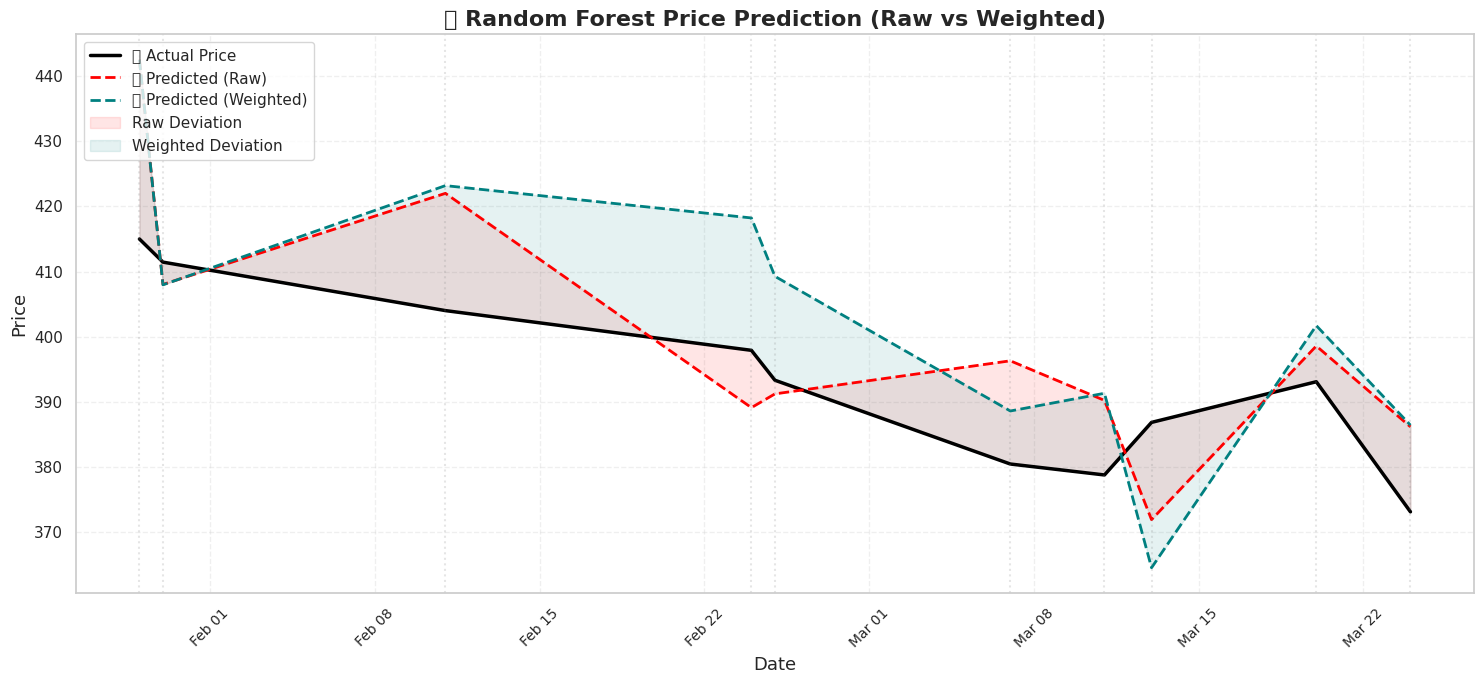

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set Seaborn style for aesthetics
sns.set(style="whitegrid")

# === Plot Starts ===
plt.figure(figsize=(15, 7))

# Plot actual prices
plt.plot(plot_dates, actual_price, label='📈 Actual Price', color='black', linewidth=2.5)

# Plot predicted (raw)
plt.plot(plot_dates, predicted_price_raw, label='🔴 Predicted (Raw)', linestyle='--', color='red', linewidth=2)

# Plot predicted (weighted)
plt.plot(plot_dates, predicted_price_weighted, label='🟢 Predicted (Weighted)', linestyle='--', color='teal', linewidth=2)

# Fill error area between prediction and actual
plt.fill_between(plot_dates, predicted_price_raw, actual_price, color='red', alpha=0.1, label='Raw Deviation')
plt.fill_between(plot_dates, predicted_price_weighted, actual_price, color='teal', alpha=0.1, label='Weighted Deviation')

# Titles and labels
plt.title("🧠 Random Forest Price Prediction (Raw vs Weighted)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=13)
plt.ylabel("Price", fontsize=13)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=11)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=11, loc='upper left')

# Improve date formatting
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Add vertical lines for clarity (optional)
for i in range(0, len(plot_dates), max(len(plot_dates)//10, 1)):
    plt.axvline(plot_dates[i], color='gray', linestyle=':', alpha=0.2)

plt.tight_layout()
plt.show()


# LSTM

In [34]:
import numpy as np

# LSTM expects 3D input: (samples, timesteps, features)
# We'll just use 1 timestep here (can expand later)
X_train_r_lstm = np.expand_dims(X_train_r, axis=1)
X_test_r_lstm = np.expand_dims(X_test_r, axis=1)

X_train_w_lstm = np.expand_dims(X_train_w, axis=1)
X_test_w_lstm = np.expand_dims(X_test_w, axis=1)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [36]:
lstm_raw = build_lstm_model((X_train_r_lstm.shape[1], X_train_r_lstm.shape[2]))
history_raw = lstm_raw.fit(X_train_r_lstm, y_train_r, epochs=15, batch_size=32, validation_split=0.1, verbose=1)

lstm_weighted = build_lstm_model((X_train_w_lstm.shape[1], X_train_w_lstm.shape[2]))
history_weighted = lstm_weighted.fit(X_train_w_lstm, y_train_w, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4441 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5559 - loss: 0.6930 - val_accuracy: 0.2000 - val_loss: 0.6939
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6294 - loss: 0.6905 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6118 - loss: 0.6912 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6294 - loss: 0.6893 - val_accuracy: 0.2000 - val_loss: 0.6945
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6957 - loss: 0.6896 - val_accuracy: 0.2000 - val_loss: 0.6956
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5663 - loss: 0.6896 - val_accuracy: 0.2000 - val_loss: 0.6967
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6294 - loss: 0.6890 - val_accuracy: 0.2000 - val_loss: 0.6976
Epoch 9/15

In [37]:
from sklearn.metrics import classification_report

# Predict
preds_raw = (lstm_raw.predict(X_test_r_lstm) > 0.5).astype(int)
preds_weighted = (lstm_weighted.predict(X_test_w_lstm) > 0.5).astype(int)

# Print results
print("🔴 LSTM Raw")
print(classification_report(y_test_r, preds_raw, digits=4))

print("🟢 LSTM Weighted")
print(classification_report(y_test_w, preds_weighted, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
🔴 LSTM Raw
              precision    recall  f1-score   support

           0     0.2500    0.1667    0.2000         6
           1     0.2857    0.4000    0.3333         5

    accuracy                         0.2727        11
   macro avg     0.2679    0.2833    0.2667        11
weighted avg     0.2662    0.2727    0.2606        11

🟢 LSTM Weighted
              precision    recall  f1-score   support

           0     0.5556    0.8333    0.6667         6
           1     0.5000    0.2000    0.2857         5

    accuracy                         0.5455        11
   macro avg     0.5278    0.5167    0.4762        11
weighted avg     0.5303    0.5455    0.4935        11



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your CSVs
price_df = pd.read_csv('stock_prices.csv')      # must include 'date' and 'close'
sentiment_df = pd.read_csv('sentiments.csv')    # must include 'date' and sent1–sent5

# Merge and sort
data = pd.merge(price_df, sentiment_df, on='date').sort_values('date')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['close'] + [f'sent{i+1}' for i in range(5)]])
